In [2]:
%reload_ext autoreload
#!pip install neptune.client

In [3]:
%autoreload
from architectures.timegan_cnn_D import *
from utils import *
from trainers import *
import torch
import numpy as np
np.random.seed(42)

trainset = DatasetSinus(num=600, seq_len=100, alpha=0.7, noise=0)
testset = DatasetSinus(num=300, seq_len=100, alpha=0.7, noise=0)
print(len(trainset))
print(trainset[0][0].size())


600
torch.Size([100, 3])


In [5]:
%autoreload
import neptune.new as neptune

run = neptune.init_run(
    project="kohmann/timeGAN",
    name="timegan_cnn_D",
    tags=["cnn","D" "batchnorm", "temporal"],
    description="Testing e=0.7",
    source_files=["timegan_cnn_D.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)


device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "model_name": "model_cnn_d.pt",
    "n_epochs": 2500,
    "l_rate": 0.0001,
    "batch_size": 64,
    "num_layers": 2,
    "hidden_dim": 20,
    "Z_dim": 100,
    "dis_thresh": 0.15,
    "dataset": "sinus",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
    "optimizer": "Adam",
}
run["parameters"] = params

model = TimeGAN(params)
timegan_trainer(model, trainset, params, neptune_logger=None, continue_training=False)
# Generate random synthetic data
gen_z = timegan_generator(model, torch.tensor(testset.T), params["model_name"], torch.device(device), testset[0][0].size(0), 100)

log_visualizations(testset, gen_z, run) # logs pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload(params["model_name"])

run.stop()

https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-114
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.

Start Embedding Network Training


Epoch: 2499, Loss: 0.0071: 100%|██████████| 2500/2500 [07:01<00:00,  5.93it/s]



Start Training with Supervised Loss Only


Epoch: 2499, Loss: 0.0024: 100%|██████████| 2500/2500 [05:04<00:00,  8.21it/s]



Start Joint Training


Epoch: 2499, E: 0.1468, G: 5.1635, D: 0.6455: 100%|██████████| 2500/2500 [56:30<00:00,  1.36s/it]


Training Complete and model_cnn_d.pt saved

Generating Data...Done


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Real std:  [1.0470895 0.9346768]
Fake std:  [0.8085075  0.90301925]
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 40 operations to synchronize with Neptune. Do not kill this process.
All 40 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-114


In [ ]:
%autoreload
import neptune.new as neptune

run = neptune.init_run(
    project="kohmann/timeGAN",
    name="timegan_cnn_D",
    tags=["cnn","D" "batchnorm", "temporal", "more epochs on last model"],
    description="Testing e=0.7",
    source_files=["timegan_cnn_D.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)


device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "model_name": "model_cnn_d2_meta_moreEpochs.pt",
    "n_epochs": 1000,
    "l_rate": 0.0001,
    "batch_size": 64,
    "num_layers": 2,
    "hidden_dim": 20,
    "Z_dim": 100,
    "dis_thresh": 0.15,
    "dataset": "sinus",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
    "optimizer": "Adam",
}
run["parameters"] = params

model = TimeGAN(feature_dim=params["feature_dim"],
                hidden_dim=params["hidden_dim"],
                num_layers=params["num_layers"],
                padding_value=0.,
                Z_dim=params["Z_dim"],
                max_seq_len=params["max_seq_len"],
                batch_size=params["batch_size"],
                device=torch.device(params["device"]))

model.load_state_dict(torch.load("model_cnn_d2_meta.pt", map_location=device))

timegan_trainer(model,
                trainset,
                batch_size=params["batch_size"],
                device=torch.device(params["device"]),
                learning_rate=params["l_rate"],
                n_epochs=params["n_epochs"],
                max_seq_len=params["max_seq_len"],
                dis_thresh=params["dis_thresh"],
                neptune_logger=run,
                model_name=params["model_name"]
                )
# Generate random synthetic data
gen_z = timegan_generator(model, torch.tensor(testset.T), params["model_name"], torch.device(device), testset[0][0].size(0), 100)


r = np.array([data[0].numpy() for data in testset])
f_pca = visualization(r, gen_z, 'pca')
run["PCA"].upload(f_pca)
plt.close(f_pca)
f_tsne = visualization(r, gen_z, 'tsne')
run["tsne"].upload(f_tsne)
plt.close(f_tsne)

run["mode_collapse"] = modeCollapseEvaluator(r, gen_z)
run["model_checkpoint"].upload(params["model_name"])

run.stop()

https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-115
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.

Start Embedding Network Training


Epoch: 601, E: 0.1332, G: 4.6762, D: 0.3320:  60%|██████    | 602/1000 [13:45<09:23,  1.42s/it]

In [5]:

gen_z = timegan_generator(model, torch.tensor(testset.T), params["model_name"], torch.device(device), testset[0][0].size(0),
                          100)


Generating Data...Done


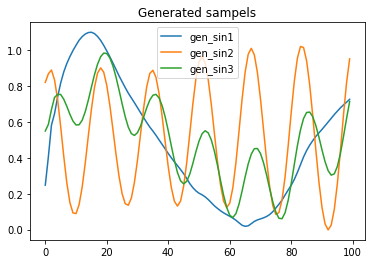

In [24]:
sample = 14
plt.plot(gen_z[sample][:, 0], label="gen_sin1")
plt.plot(gen_z[sample][:, 1], label="gen_sin2")
plt.plot(gen_z[sample][:, 2], label="gen_sin3")
plt.title("Generated sampels")
plt.legend()

In [7]:
def create_sin3(sin1, sin2, temporal=False):
    sin1, sin2 = np.array(sin1), np.array(sin2)
    e = 0.7  # temporal information weight
    seq_len = len(sin1)
    importance = np.array([e ** i for i in range(seq_len)])

    if temporal:
        sin3 = []
        for i in range(1, seq_len + 1):
            sin3.append(((importance[:i][::-1] * sin1[:i] + importance[:i][::-1] * sin2[:i]) / 2).sum())
        return sin3
    else:
        return [(s1 + s2) / 2 for s1, s2 in zip(sin1, sin2)]

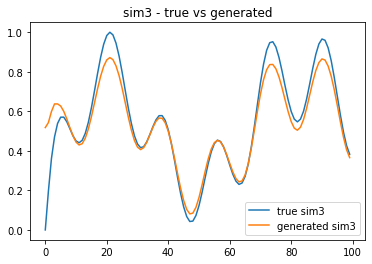

In [10]:
sample = 1
real_combo = create_sin3(gen_z[sample][:,0], gen_z[sample][:,1], temporal=True)
real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))[0]
gen_combo = gen_z[sample][:,2]
plt.plot(real_comb_scaled, label="true sim3")
plt.plot(gen_combo, label="generated sim3")
plt.title("sim3 - true vs generated")
plt.legend()

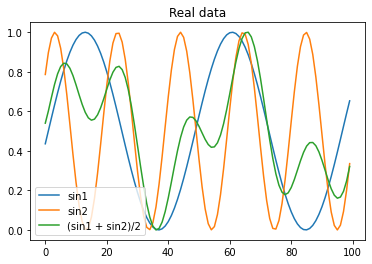

In [10]:
sample = trainset.__getitem__(9)
plt.plot(sample[0][:,0], label="sin1")
plt.plot(sample[0][:,1], label="sin2")
plt.plot(sample[0][:,2], label="(sin1 + sin2)/2")
plt.title("Real data")
plt.legend()

In [19]:
real_comb = create_sin3(gen_z[sample][:,0], gen_z[sample][:,0], temporal=True)
real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))
plt.plot(real_comb_scaled[0])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### CNN layer testing

In [2]:
def printLayerShapes(layers, input):
    for layer in layers:
        output = layer(input)
        print(f"{type(layer).__name__}: {list(input.size())} --> {list(output.size())}")
        input = output

In [3]:
import torch
import torch.nn as nn
input = torch.randn(20, 100, 20)


## Discrininator
layers = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=20, kernel_size=(5), stride=2, bias=False)
            #,nn.Flatten(start_dim=1)
            ,nn.BatchNorm1d(20)
            ,nn.LeakyReLU()
            ,nn.Conv1d(in_channels=20, out_channels=40, kernel_size=(7), stride=2, bias=False)
            #,nn.Flatten(start_dim=1)
            ,nn.BatchNorm1d(40)
            ,nn.LeakyReLU()
            ,nn.Flatten(start_dim=1)
            ,nn.Linear(40, 1)
        )
printLayerShapes(layers, input)

Conv1d: [20, 100, 20] --> [20, 20, 8]
BatchNorm1d: [20, 20, 8] --> [20, 20, 8]
LeakyReLU: [20, 20, 8] --> [20, 20, 8]
Conv1d: [20, 20, 8] --> [20, 40, 1]
BatchNorm1d: [20, 40, 1] --> [20, 40, 1]
LeakyReLU: [20, 40, 1] --> [20, 40, 1]
Flatten: [20, 40, 1] --> [20, 40]
Linear: [20, 40] --> [20, 1]


In [7]:
## Generator architecture
input = torch.randn(20, 100, 100)

layers = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=100, kernel_size=6, stride=2, bias=False)
            , nn.BatchNorm1d(100)
            , nn.LeakyReLU()
            , nn.Conv1d(in_channels=100, out_channels=100, kernel_size=9, stride=2, bias=True)
            , nn.Sigmoid()
        )

print(f"Generator architecture\nInput: {input.size()}\n")
printLayerShapes(layers, input)

Generator architecture
Input: torch.Size([20, 100, 100])

Conv1d: [20, 100, 100] --> [20, 100, 48]
BatchNorm1d: [20, 100, 48] --> [20, 100, 48]
LeakyReLU: [20, 100, 48] --> [20, 100, 48]
Conv1d: [20, 100, 48] --> [20, 100, 20]
Sigmoid: [20, 100, 20] --> [20, 100, 20]


In [124]:
# Recovery
layers = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(5), stride=2, bias=False)
            #,nn.Flatten(start_dim=1)
            ,nn.BatchNorm1d(100)
            ,nn.LeakyReLU()
            ,nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(3), stride=2, bias=True)

        )
printLayerShapes(layers, input)


Conv1d: [20, 100, 20] --> [20, 100, 8]
BatchNorm1d: [20, 100, 8] --> [20, 100, 8]
LeakyReLU: [20, 100, 8] --> [20, 100, 8]
Conv1d: [20, 100, 8] --> [20, 100, 3]


In [132]:
output = layers[0](input)